In [1]:
# Import packages
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet50_Weights, resnet50
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.io.image import read_image
from matplotlib import colormaps
import numpy as np
import PIL
from PIL import Image
import pandas as pd
from scipy import ndimage
import os
import gc

Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

PyTorch version= 2.3.1+cu118
CUDA available= True


#### Load trained KGM Author Model

Model from: https://github.com/noagarcia/context-art-classification/blob/master/model_kgm.py

In [2]:
class KGM(nn.Module):
    # Inputs an image and ouputs the prediction for the class and the projected embedding into the graph space

    def __init__(self, num_class):
        super(KGM, self).__init__()

        # Load pre-trained visual model
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])

        # Classifier
        self.classifier = nn.Sequential(nn.Linear(2048, num_class))

        # Graph space encoder
        self.nodeEmb = nn.Sequential(nn.Linear(2048, 128))


    def forward(self, img):

        visual_emb = self.resnet(img)
        visual_emb = visual_emb.view(visual_emb.size(0), -1)
        pred_class = self.classifier(visual_emb)
        graph_proj = self.nodeEmb(visual_emb)

        return pred_class

# Load KGM author model
model = KGM(350)
model.cuda()
checkpoint = torch.load(r'.\\Data\\Model\\best-kgm-author-model.pth\\best-kgm-author-model.pth', encoding='latin1', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

KGM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

#### Add hooks to model to get activations and gradients for Grad-CAM

Reference: https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569

In [3]:
# Define hook functions
def backward_hook(module, grad_input, grad_output):
    module.gradients = grad_output[0]

def forward_hook(module, input, output):
    module.activations = output

def compute_gradcam(img_tensor):
    # Register hooks
    backward_hook_handle = model.resnet[7].register_full_backward_hook(backward_hook)
    forward_hook_handle = model.resnet[7].register_forward_hook(forward_hook)
    
    try:   
        output = model(img_tensor.unsqueeze(0))
        output.sum().backward()

        # Retrieve gradients and activations
        gradients = model.resnet[7].gradients
        activations = model.resnet[7].activations

        # Compute pooled gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Apply gradients to activations
        for i in range(activations.size(1)):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # Apply ReLU to the heatmap
        heatmap = F.relu(heatmap)

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

    finally:
        # Ensure hooks are removed
        backward_hook_handle.remove()
        forward_hook_handle.remove()

    torch.cuda.empty_cache()  # Clear GPU cache

    return heatmap.detach().cpu().numpy()

#### Setup processing and plotting for Grad-CAMs

In [4]:
def create_image_tensor(img_path): 
    image_path = r'.\\Data\\Images\\'
    img = read_image(image_path + img_path)
    img_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(Device)
    return img_tensor
    

def process_images(image_paths, batch_size=32):
    for start in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[start:start + batch_size]
        for img_path in batch_paths:
            # Load and preprocess the image
            try:
                img_tensor = create_image_tensor(img_path)
            except: 
                continue
            
            # Compute Grad-CAM
            heatmap = compute_gradcam(img_tensor)
            
            # Save heatmap
            file_path = '.\\Data\\Grad-CAMs Author\\'
            np.save(os.path.join(file_path, img_path.replace('.jpg', '.npy')), heatmap)


def plot_gradcam(heatmap, img_tensor): 
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax2.axis('off')
    ax1.matshow(heatmap)
    ax2.imshow(to_pil_image(img_tensor, mode='RGB'))
    overlay = to_pil_image(heatmap, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    ax2.imshow(overlay, alpha=0.4, interpolation='nearest')
    plt.show()

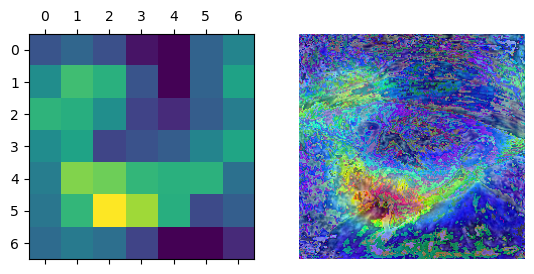

In [5]:
# Sanity
img_tensor = create_image_tensor("17291-selfpo18.jpg")
heatmap = compute_gradcam(img_tensor)
plot_gradcam(heatmap, img_tensor)

#### Create dataset for Painters Experiment

In [6]:
authors = ['GOGH, Vincent van', 'MONET, Claude', 'GAUGUIN, Paul', 'MANET, Edouard',
           'RAFFAELLO Sanzio', 'MICHELANGELO Buonarroti','REMBRANDT Harmenszoon van Rijn','EYCK, Jan van']
df = pd.read_csv(r'.\\Data\\semart_train.csv', encoding = "ISO-8859-1", sep='\t')
author_experiment = df[df['AUTHOR'].isin(authors)]
images_path = r'.\\Data\\Images\\'
im_list = author_experiment['IMAGE_FILE']

if len(os.listdir('.\\Data\\Grad-CAMs Author\\')) == 0:
    process_images(im_list, batch_size=64)

Source for Grad-CAM metrics: https://github.com/Fuminides/context-art-classification/blob/master/analyze_gradcam.py

In [7]:
def relevant_area(image_numpy):
    '''
    Returns the relevant area of the image.
    '''
    # Get the image size
    height, width = image_numpy.shape
    avg_value = np.mean(image_numpy, axis=None)
    std_value = np.std(image_numpy, axis=None)

    return np.mean(image_numpy > np.maximum(avg_value, 0), axis=None)


def atention_focus(image_numpy):
    # vector_data = image_numpy.flatten()
    dx = ndimage.sobel(image_numpy, axis=0)
    dy = ndimage.sobel(image_numpy, axis=1)
    magnitude = np.hypot(dx, dy)

    return np.max(magnitude)
    

def relevant_parts(image_numpy):
    avg_value = np.mean(image_numpy, axis=None)

    # Partition the  image in 9 parts
    height, width = image_numpy.shape
    subdivisions = 6
    # Get the mean of each part
    mean_parts = np.zeros((subdivisions,subdivisions))

    for i in range(subdivisions):
        for j in range(subdivisions):
            mean_parts[i,j] = np.mean(image_numpy[i*height//subdivisions:(i+1)*height//subdivisions, j*width//subdivisions:(j+1)*width//subdivisions])
    
    min_mean_idx = mean_parts.flatten().argmin()
    min_mean = mean_parts.flatten()[min_mean_idx]

    relevant_areas = np.zeros((subdivisions,subdivisions))

    for i in range(subdivisions):
        for j in range(subdivisions):
            if mean_parts[i,j] > avg_value:
                relevant_areas[i, j] = 1
    
    _, n_components = ndimage.label(relevant_areas)
    return n_components


def sobel_filter(np_image):
    # Apply Sobel filter
    edges_x = ndimage.sobel(np_image, axis=0)
    edges_y = ndimage.sobel(np_image, axis=1)
    # Compute gradient magnitude
    gradient_magnitude = np.hypot(edges_x, edges_y)
    return gradient_magnitude

In [8]:
def compute_metrics(image): 
    image_name = image.replace('.npy', '.jpg')
    heatmap = np.load(r'.\\Data\\Grad-CAMs Author\\' + image)
    ra = relevant_area(heatmap)
    af = atention_focus(heatmap)
    rp = relevant_parts(heatmap)

    return [image_name, ra, af, rp]

In [9]:
%%time
grad_cams_path = r'.\\Data\\Grad-CAMs Author\\'
gc_list = os.listdir(grad_cams_path)[:]  

names, ras, afs, rps = [], [], [], []
for ix, gc in enumerate(gc_list):
    results = compute_metrics(gc)
    names.append(results[0])
    ras.append(results[1])
    afs.append(results[2])
    rps.append(results[3])    

CPU times: total: 453 ms
Wall time: 10.5 s


In [10]:
gradcam_df = pd.DataFrame({'name':names, 'relevant_area':ras, 'maximum_gradient':afs, 'super_regions':rps})
gradcam_df.to_csv(r'.\\Data\\gradcam_features.csv')